Chargement de la base de donnée session8.db


In [5]:
!pip install mplfinance

In [7]:
import pandas as pd # chargement des bases de donnees
import sqlite3  # chargement/ ecriture dans les bases de donnees

import requests # chargement des donnees depuis l'API
from requests import get#

import pprint #

import os.path #lire des fichiers
if not os.path.isfile("session8.db"):
    import urllib.request #telecharger un fichier depuis une url
    urllib.request.urlretrieve("http://homepages.ulb.ac.be/~choffreu/session8.db", "session8.db")#telechargement du fichier depuis lurl specifie sous le nom de session8.db

SESSION8 = sqlite3.connect('session8.db') #creation de la connexion avec la BDD (rouge)
cursor_SESSION8 = SESSION8.cursor() 

query = '''
  SELECT name, gsector, ticker
  FROM Companies 
  WHERE ticker IN ("GOOGL", "AMZN", "FB", "AAPL", "IDMO", "FFR", "TECTP","XTN", "FCAN", "MSFT")
'''
information_from_session8 = pd.read_sql_query(query,SESSION8) 

print(information_from_session8)

##ADD 5 companies







                           name                     gsector ticker
0                  ALPHABET INC  Telecommunication Services  GOOGL
1                  FACEBOOK INC  Telecommunication Services     FB
2        TECTONIC FINANCIAL INC                         N/A  TECTP
3                AMAZON.COM INC      Consumer Discretionary   AMZN
4   SPDR S&P TRANSPORTATION ETF                         N/A    XTN
5  FIRST TR FTSE EPRA/NAREIT DV                         N/A    FFR
6  INVESCO S&P INTL DEV MTM ETF                         N/A   IDMO
7   FIRST TR CANADA ALPHADEX FD                         N/A   FCAN
8                     APPLE INC      Information Technology   AAPL


Intialisation de la BDD du Projet:

-Creation des tableaux

-Copie des infos de la BDD session8 dans la BDD du projet



In [0]:
PROJET = sqlite3.connect('PROJET.db')
cursor_PROJET = PROJET.cursor()

#########Tableau Companies#########


####Ticker est la cle primaire pour permettre que ce soit une cle secondaire dans Candlesticks et alerts
cursor_PROJET.execute("""
CREATE TABLE IF NOT EXISTS Companies(
  ticker TEXT PRIMARY KEY UNIQUE,
  gsector TEXT,
  name TEXT
)
""")
PROJET.commit()
for i in range(0, len(information_from_session8) ):

  cursor_PROJET.execute(
                        """INSERT INTO
                              Companies(ticker,gsector,name) 
                              VALUES   (  ? ,   ?   ,  ?   )
                        """,(
                              information_from_session8["ticker"][i],
                              information_from_session8["gsector"][i],
                              information_from_session8["name"][i] 
                            )
                      )
  
  PROJET.commit()

cursor_PROJET.execute("INSERT INTO Companies(ticker,gsector,name) VALUES ('MSFT', 'IT Services', 'Microsoft')")
PROJET.commit()

#########Tableau Directions#########
query='''
        CREATE TABLE IF NOT EXISTS Directions (
          direction TEXT PRIMARY KEY UNIQUE
        )
'''

cursor_PROJET.execute(query)
PROJET.commit()

directions=["max","min"]
for i in directions:
  cursor_PROJET.execute(
                        """INSERT INTO
                              Directions(direction) 
                              VALUES   ( ? )
                        """,(i,))
  
  PROJET.commit()

#########Tableau Sources#########
query="""
        CREATE TABLE IF NOT EXISTS Sources (
          source TEXT PRIMARY KEY UNIQUE
        )
      """
cursor_PROJET.execute(query)
PROJET.commit()
sources=["open","close","high","low"]
for i in sources:
  cursor_PROJET.execute(
                        """INSERT INTO
                              Sources(source) 
                              VALUES   ( ? )
                        """,( 
                             i, 
                            )
                      )
  
  PROJET.commit()

#########Tableau Candlesticks#########
query="""
        CREATE TABLE IF NOT EXISTS Candlesticks (
          id INTEGER PRIMARY KEY,
          open_price FLOAT,
          high_price FLOAT,
          close_price FLOAT,
          low_price FLOAT,
          volume INT,
          date DATE,
          ticker TEXT,
          FOREIGN KEY (ticker) REFERENCES Companies (ticker)
        )
      """
cursor_PROJET.execute(query)
PROJET.commit()
#########Tableau Alerts#########
query="""
        CREATE TABLE IF NOT EXISTS Alerts (
          name TEXT PRIMARY KEY UNIQUE,
          date_start DATE,
          date_end DATE,
          start_value FLOAT,
          end_value FLOAT,
          source TEXT,
          direction TEXT,
          ticker TEXT,
          FOREIGN KEY (source) REFERENCES Sources (source)
          FOREIGN KEY (direction) REFERENCES Directions (direction)
          FOREIGN KEY (ticker) REFERENCES Companies (ticker)
        )
      """
cursor_PROJET.execute(query)
PROJET.commit()





Chargement des tickers

In [9]:

query = '''
SELECT *
FROM Companies 
'''
resultat_PROJET_COMPANIES = pd.read_sql_query(query,PROJET)
print(resultat_PROJET_COMPANIES)

  ticker                     gsector                          name
0  GOOGL  Telecommunication Services                  ALPHABET INC
1     FB  Telecommunication Services                  FACEBOOK INC
2  TECTP                         N/A        TECTONIC FINANCIAL INC
3   AMZN      Consumer Discretionary                AMAZON.COM INC
4    XTN                         N/A   SPDR S&P TRANSPORTATION ETF
5    FFR                         N/A  FIRST TR FTSE EPRA/NAREIT DV
6   IDMO                         N/A  INVESCO S&P INTL DEV MTM ETF
7   FCAN                         N/A   FIRST TR CANADA ALPHADEX FD
8   AAPL      Information Technology                     APPLE INC
9   MSFT                 IT Services                     Microsoft


Chargement des données depuis l'API

In [0]:
token = "bpog5jfrh5ra872e4vkg"
liste_des_actions = resultat_PROJET_COMPANIES["ticker"]
        
from datetime import datetime
start_date = datetime(2019, 1, 1)
#start_timestamp = int(datetime.timestamp(start_date)) # <-- ca donne le nombre de secondes écoulées entre le 1/1/1970 à 00:00 et 1/1/2020 
end_timestamp = int(datetime.timestamp(datetime.now())) #Prise des dates jusqua maintenant
#start_date = datetime(2020, 1, 13) # <-- LUNDI 13 janvier 2020 
start_timestamp = int(datetime.timestamp(start_date)) # <-- ca donne le nombre de secondes écoulées entre le 1/1/1970 à 00:00 et 1/1/2020 
#end_date = datetime(2020, 1, 17)   # <-- Vendredi 17 janvier 2020 NON COMPRIS
#end_timestamp = int(datetime.timestamp(end_date))


companies_candle = {}

for i in range(0, len(liste_des_actions)):
      API_URL = 'https://finnhub.io/api/v1/stock/candle?symbol=' + liste_des_actions[i] + '&resolution=D&from=' + str(start_timestamp) + '&to=' + str(end_timestamp) + '&token=' + token
      
      REPONSE_DE_L_API = requests.get(API_URL).json()
      companies_candle[liste_des_actions[i]] = REPONSE_DE_L_API
#pprint.pprint(companies_candle)

Remplissage du tableau Candlesticks


In [11]:
for i in companies_candle.keys():
  if companies_candle[i]["s"] == "ok":
    for k in range(len(companies_candle[i]["o"])):
      date=datetime.fromtimestamp(int(companies_candle[i]["t"][k])).strftime("%Y/%m/%d")
      cursor_PROJET.execute(
                          """INSERT INTO
                                Candlesticks(open_price,high_price,close_price,low_price,volume,date,ticker) 
                                VALUES   (?,?,?,?,?,?,?)
                          """,(
                                companies_candle[i]["o"][k],
                                companies_candle[i]["h"][k],
                                companies_candle[i]["c"][k],
                                companies_candle[i]["l"][k],
                                companies_candle[i]["v"][k],
                                date,
                                i
                                
                              )
                        )
    
    PROJET.commit()

query = '''
SELECT *
FROM Candlesticks
'''
resultat_PROJET_CANDLESTICKS = pd.read_sql_query(query,PROJET)
print(resultat_PROJET_CANDLESTICKS)

        id  open_price  high_price  ...    volume        date  ticker
0        1   1027.2000     1060.79  ...   1593400  2019/01/02   GOOGL
1        2   1050.6700     1066.26  ...   2098000  2019/01/03   GOOGL
2        3   1042.5601     1080.00  ...   2301100  2019/01/04   GOOGL
3        4   1080.9700     1082.70  ...   2372300  2019/01/07   GOOGL
4        5   1086.0000     1093.35  ...   1770700  2019/01/08   GOOGL
...    ...         ...         ...  ...       ...         ...     ...
3232  3233    174.1100      175.06  ...  32790800  2020/04/23    MSFT
3233  3234    172.0600      174.56  ...  34305300  2020/04/24    MSFT
3234  3235    176.5900      176.90  ...  33194400  2020/04/27    MSFT
3235  3236    175.5900      175.67  ...  34276600  2020/04/28    MSFT
3236  3237    173.2200      177.59  ...  36017583  2020/04/29    MSFT

[3237 rows x 8 columns]


![Texte alternatif…](https://imgur.com/xgvpxyx.png)

QUESTION 1:

In [13]:
query = '''
  SELECT ticker
  FROM Companies '''
PROJET = sqlite3.connect('PROJET.db')
cursor_PROJET = PROJET.cursor()
liste_tickers = pd.read_sql_query(query,PROJET)
max_dict={}
for index, row in liste_tickers.iterrows():
    query = '''
      SELECT open_price,close_price
      FROM Candlesticks WHERE ticker IN (\"'''+row['ticker']+"\")"
    cd_df=pd.read_sql_query(query,PROJET)
    difference_q1=0
    for index_cd, row_cd in cd_df.iterrows():
        if(index_cd!=0):
          if((cd_df.loc[index_cd-1,"close_price"]/row_cd["open_price"])>difference_q1):
            difference_q1=cd_df.loc[index_cd-1,"close_price"]/row_cd["open_price"]

    max_dict[row['ticker']]=difference_q1

print(max_dict)

{'AAPL': 1.1488737342426123, 'AMZN': 1.0874134181333042, 'FB': 1.1179096638655464, 'FCAN': 1.160220994475138, 'FFR': 1.2027194066749074, 'GOOGL': 1.114407907416415, 'IDMO': 1.1164069660861595, 'MSFT': 1.1345, 'TECTP': 1.149821640903686, 'XTN': 1.0713309024612578}


QUESTION 2:

In [15]:
query = '''
  SELECT ticker
  FROM Companies '''
PROJET = sqlite3.connect('PROJET.db')
cursor_PROJET = PROJET.cursor()
liste_tickers = pd.read_sql_query(query,PROJET)
max_df={}
for index, row in liste_tickers.iterrows():
    query = '''
      SELECT high_price,low_price
      FROM Candlesticks WHERE ticker IN (\"'''+row['ticker']+"\")"
    cd_df=pd.read_sql_query(query,PROJET)
    diff_df=(cd_df.assign(difference=lambda x :x["high_price"]-x["low_price"])).loc[:,"difference"]
    max_df[row["ticker"]]=diff_df.max()

print(max_df)

{'AAPL': 26.970000000000027, 'AMZN': 168.53999999999996, 'FB': 16.03, 'FCAN': 1.459999999999999, 'FFR': 3.770000000000003, 'GOOGL': 102.11000000000013, 'IDMO': 0.9700000000000024, 'MSFT': 21.180000000000007, 'TECTP': 0.9599999999999991, 'XTN': 4.519999999999996}


QUESTION 3:

In [16]:
def evolution (ticker,date_debut,date_fin):
  query = '''
      SELECT close_price,date
      FROM Candlesticks WHERE (ticker IN (\"'''+ticker+"\")"+'''
      AND (date=\''''+date_debut.strftime("%Y/%m/%d")+"\' OR date=\'"+date_fin.strftime("%Y/%m/%d")+"\'))"
  
  PROJET = sqlite3.connect('PROJET.db')
  cursor_PROJET = PROJET.cursor()
  df=pd.read_sql_query(query,PROJET)
  return (df.loc[1,"close_price"]-df.loc[0,"close_price"])/df.loc[0,"close_price"]

evolution("AAPL",datetime(2020, 1, 13),datetime(2020, 1, 15))

-0.0177309439676931

QUESTION 4:

In [17]:
def nbVar (ticker,date_debut,date_fin,valeur_limite):
  query = '''
      SELECT open_price,close_price
      FROM Candlesticks WHERE (ticker IN (\"'''+ticker+"\")"+'''
      AND (date>=\''''+date_debut.strftime("%Y/%m/%d")+"\' AND date<=\'"+date_fin.strftime("%Y/%m/%d")+"\'))"
  PROJET = sqlite3.connect('PROJET.db')
  cursor_PROJET = PROJET.cursor()
  df=pd.read_sql_query(query,PROJET)
  diff_df=(df.assign(difference=lambda x :abs(x["open_price"]-x["close_price"]))).loc[:,"difference"]
  return diff_df[diff_df > valeur_limite].count()

print(nbVar("AAPL",datetime(2020, 1, 13),datetime(2020, 1, 15),1))

2


QUESTION 5:

In [89]:
#!pip install plotly
import plotly.graph_objects as go
def draw_graph (ticker, date_debut,date_fin):
    query = '''
      SELECT open_price,close_price,high_price,low_price,date
      FROM Candlesticks WHERE (ticker IN (\"'''+ticker+"\")"+'''
      AND (date>=\''''+date_debut.strftime("%Y/%m/%d")+"\' AND date<=\'"+date_fin.strftime("%Y/%m/%d")+"\'))"
    PROJET = sqlite3.connect('PROJET.db')
    cursor_PROJET = PROJET.cursor()
    df=pd.read_sql_query(query,PROJET) 
    layout =dict(
        xaxis=go.layout.XAxis(rangeslider=dict (visible = False)),
        
    )
    max_value=df[["open_price","close_price"]].max().max()
    min_value=df[["open_price","close_price"]].min().min()
    fig = go.Figure(data=[go.Candlestick(x=df['date'],
                open=df['open_price'],
                high=df['high_price'],
                low=df['low_price'],
                close=df['close_price'])],layout=layout)
    fig.add_shape(
            type="line",
            x0=df['date'][0],
            y0=max_value,
            x1=df['date'].iloc[-1],
            y1=max_value,
            line=dict(
                color="orange",
                width=1,
                dash="dashdot",
            ),
    )
    fig.add_shape(
            type="line",
            x0=df['date'][0],
            y0=min_value,
            x1=df['date'].iloc[-1],
            y1=min_value,
            line=dict(
                color="orange",
                width=1,
                dash="dashdot",
            ),
    )
    fig.show()
    
draw_graph("AAPL",datetime(2020, 1, 1),datetime.now())    

QUESTION 6:

In [98]:
def add_alert (name, ticker, date_start,date_end,start_value,end_value,source,direction):
    PROJET = sqlite3.connect('PROJET.db')
    cursor_PROJET = PROJET.cursor()    
    dir_df=pd.read_sql_query("SELECT * FROM Directions",PROJET)
    source_df=pd.read_sql_query("SELECT * FROM Sources",PROJET)
    if (not(direction in list(dir_df["direction"])) or not(source in list(source_df["source"]))):
      return#Si les elements source et direction ne correspondent pas a des elemnts de source ou direction de leurs tableaux,on najoute pas lelement
    
    cursor_PROJET.execute(
                          """INSERT INTO
                                Alerts(name,date_start,date_end,start_value,end_value,source,direction,ticker) 
                                VALUES   (?,?,?,?,?,?,?,?)
                          """,(
                                name,
                                date_start.strftime("%Y/%m/%d"),
                                date_end.strftime("%Y/%m/%d"),
                                str(start_value),
                                str(end_value),
                                source,
                                direction,
                                ticker
                              )
    )
    PROJET.commit()


PROJET = sqlite3.connect('PROJET.db')
cursor_PROJET = PROJET.cursor()
query="SELECT * FROM Alerts"
add_alert("test4","AAPL",datetime(2019,7,9),datetime(2019,12,21),200,260,"open","max")
df=pd.read_sql_query(query,PROJET)
print(df)

    name  date_start    date_end  ...  source  direction ticker
0  test3  2019/07/09  2019/12/21  ...    open        max   AAPL
1   test  2019/07/09  2019/12/21  ...    open        max   AAPL
2  test1  2019/07/09  2019/12/21  ...    open        max   AAPL
3  test2  2019/07/09  2019/12/21  ...    open        max   AAPL
4  test4  2019/07/09  2019/12/21  ...    open        max   AAPL

[5 rows x 8 columns]


QUESTION 7:

In [135]:
def nb_alert(name):
  PROJET = sqlite3.connect('PROJET.db')
  cursor_PROJET = PROJET.cursor()
  
  query="SELECT * FROM Alerts WHERE name=\'"+name+"\'"#importation de alert by name
  alert_df=pd.read_sql_query(query,PROJET)

  query='''SELECT open_price,high_price,low_price,close_price,date FROM Candlesticks
          WHERE (ticker =\"'''+alert_df.ticker[0]+"\" AND (date >=\'"+alert_df.date_start[0]+"\' AND date <=\'"+alert_df.date_end[0]+"\'))"
  df_tick=pd.read_sql_query(query,PROJET)
  slope = (float(alert_df.end_value[0])-float(alert_df.start_value[0]))/df_tick.shape[0]
  equation = lambda t : slope*t+float(alert_df.start_value[0])
  count=0
  for index, row in df_tick.iterrows():
    delta_days = int(index)
    delta_value=equation(delta_days)
    indice=alert_df.source[0]+"_price"
    if(float(row[indice])<delta_value):
      count+=1
  #####PARTIE AFFICHAGE#######
  layout =dict(
        xaxis=go.layout.XAxis(rangeslider=dict (visible = False)),
        
  )
  fig = go.Figure(data=[go.Candlestick(x=df_tick['date'],
              open=df_tick['open_price'],
              high=df_tick['high_price'],
              low=df_tick['low_price'],
              close=df_tick['close_price'])],layout=layout)
  fig.add_shape(
          type="line",
          x0=df_tick['date'].iloc[0],
          y0=alert_df.start_value[0],
          x1=df_tick['date'].iloc[-1],
          y1=alert_df.end_value[0],
          line=dict(
              color="orange",
              width=1,
              dash="dashdot",
          ),
  )
  fig.show()
  #######
  return count
nb_alert("test4")

54

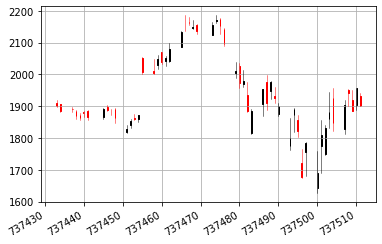

In [134]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc
def draw_enveloppe(ticker,date_start,date_end,source,pourcentage):
  PROJET = sqlite3.connect('PROJET.db')

  query = "SELECT * FROM Candlesticks WHERE ticker='"+ticker+"' AND date >= '"+date_start.strftime("%Y/%m/%d")+"' AND date <= '"+date_end.strftime("%Y/%m/%d")+"'"
  df=pd.read_sql_query(query,PROJET)
  if source=="open":
    moyenne=df['open_price'].mean()
  elif source=="close":
    moyenne=df['close_price'].mean()
  up=moyenne+moyenne*pourcentage
  down=moyenne-moyenne*pourcentage
  
  '''df.index=mpl.dates.date2num(pd.to_datetime(df.date).to_pydatetime())

  df=df.rename(columns={"open_price": "Open", "close_price": "Close","high_price":"High","low_price":"Low"})
  display(df)

  fig, ax = plt.subplots()
  candlestick_ohlc(ax, quotes=[df['date'],df['Open'],df['High'], df['Low'],df['Close']])'''
  
  #On doit se decider sur quelle librairie on va utiliser: plotly ou mplfinance.original_flavor
  ######
  df.date=mpl.dates.date2num(pd.to_datetime(df.date))
  df.index=df.date
  row_list =[] 
  for rows in df.itertuples(): 
    my_list = [rows.date, rows.open_price, rows.high_price,rows.low_price,rows.close_price] 
    row_list.append(my_list) 
  fig, ax = plt.subplots()
  candlestick_ohlc(ax, quotes=row_list)
  #####
  ax.autoscale_view()
  ax.grid(True)
  fig.autofmt_xdate()

  plt.show()

draw_enveloppe("AMZN", datetime(2020,1,9),datetime(2020,3,29), "open", 0.01)
